 Q1 — Predict stress level based on time spent on Instagram

Code (imports)

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, classification_report

RANDOM_STATE = 42
TEST_SIZE = 0.2       # keep 20% of  data for testing, and train on 80%.
PLOT_SAMPLE = 60000
pd.set_option("display.max_columns", 200)

In [101]:
TARGET = "perceived_stress_score"
MAIN_X = "daily_active_minutes_instagram"

# Confounders (edit later if needed)
NUM_CONFOUNDERS = [
    "sleep_hours_per_night",
    "exercise_hours_per_week",
    "weekly_work_hours",
    "self_reported_happiness",
    "daily_steps_count",
    "age",
]

CAT_CONFOUNDERS = [
    "income_level",
    "employment_status",
    "education_level",
    "has_children",
    "relationship_status",
    "urban_rural",
]

In [102]:
# Code (load only necessary columns)

DATA_PATH = "datas/instagram_usage_lifestyle.csv"

usecols = [TARGET, MAIN_X] + NUM_CONFOUNDERS + CAT_CONFOUNDERS
usecols = list(dict.fromkeys(usecols))  # unique

df = pd.read_csv(DATA_PATH, usecols=lambda c: c in usecols)

print("Shape:", df.shape)
display(df.head())

Shape: (1547896, 14)


,age,urban_rural,income_level,employment_status,education_level,relationship_status,has_children,exercise_hours_per_week,sleep_hours_per_night,perceived_stress_score,self_reported_happiness,daily_steps_count,weekly_work_hours,daily_active_minutes_instagram
0,51,Rural,High,Retired,Bachelor’s,Single,No,7.2,7.7,3,8,8107,49.9,5.0
1,64,Urban,Middle,Full-time employed,Other,Divorced,No,10.9,8.6,1,1,8059,15.6,74.0
2,41,Urban,Middle,Student,Bachelor’s,In a relationship,No,5.0,6.7,4,10,7872,31.8,5.0
3,27,Urban,Middle,Unemployed,Master’s,In a relationship,No,10.6,6.5,18,1,7801,43.4,233.0
4,55,Urban,Upper-middle,Full-time employed,Bachelor’s,Single,No,7.7,6.8,19,1,8005,50.2,184.0


In [103]:
# Code (data audit: missing + quick describe)

missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct.to_frame("missing_%").head(25))

display(df[[MAIN_X, TARGET]].describe())

,missing_%
age,0.0
urban_rural,0.0
income_level,0.0
employment_status,0.0
education_level,0.0
relationship_status,0.0
has_children,0.0
exercise_hours_per_week,0.0
sleep_hours_per_night,0.0
perceived_stress_score,0.0


,daily_active_minutes_instagram,perceived_stress_score
count,1.547896e+06,1.547896e+06
mean,1.882298e+02,1.998774e+01
std,1.101278e+02,1.183258e+01
min,5.000000e+00,0.000000e+00
25%,1.010000e+02,1.000000e+01
50%,1.860000e+02,2.000000e+01
75%,2.710000e+02,3.000000e+01
max,5.800000e+02,4.000000e+01


In [104]:
# Code (clean basic numeric conversion + sanity rules)

df[MAIN_X] = pd.to_numeric(df[MAIN_X], errors="coerce")
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")

for c in NUM_CONFOUNDERS:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# sanity bounds (edit if needed)
df = df[(df[MAIN_X].between(0, 1440)) | (df[MAIN_X].isna())]
df = df[(df[TARGET].between(0, 100)) | (df[TARGET].isna())]

print("After cleaning shape:", df.shape)

After cleaning shape: (1547896, 14)


### Pearson correlation

In [105]:
corr_df = df[[MAIN_X, TARGET]].dropna()
pearson_r = corr_df[MAIN_X].corr(corr_df[TARGET], method="pearson")
print(f"Pearson r = {pearson_r:.4f}")
print("Rows used:", len(corr_df))

Pearson r = 0.8345
Rows used: 1547896


### Baseline model (Linear Regression)

In [106]:
base = df[[MAIN_X, TARGET]].dropna()
X = base[[MAIN_X]]          # ✅ 2D
y = base[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# keep a safe copy for the baseline plot
X_train_base, X_test_base, y_train_base, y_test_base = X_train, X_test, y_train, y_test

print("Train:", X_train_base.shape, "Test:", X_test_base.shape)  # ✅ fixed print

Train: (1238316, 1) Test: (309580, 1)


In [107]:
# Code (fit baseline regression + metrics)

baseline_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

baseline_model.fit(X_train_base, y_train_base)

pred_train = baseline_model.predict(X_train_base)
pred_test  = baseline_model.predict(X_test_base)

mae  = mean_absolute_error(y_test_base, pred_test)
rmse = np.sqrt(mean_squared_error(y_test_base, pred_test))
r2   = r2_score(y_test_base, pred_test)

print("Baseline TEST")
print("MAE :", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R2  :", round(r2, 3))

Baseline TEST
MAE : 5.24
RMSE: 6.521
R2  : 0.697


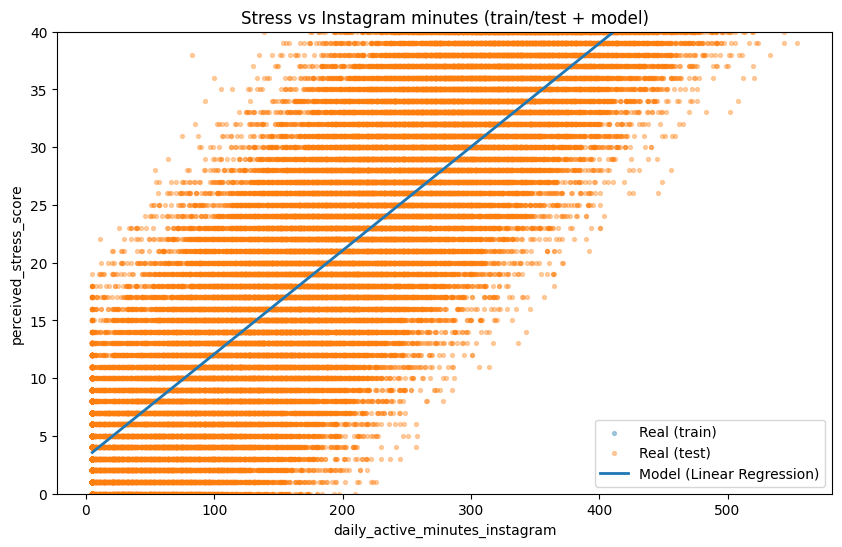

In [108]:
#Code (plot: real train + real test + model line)
plot_df = base.sample(n=min(PLOT_SAMPLE, len(base)), random_state=RANDOM_STATE)

train_idx = set(X_train_base.index)
plot_df["split"] = np.where(plot_df.index.isin(train_idx), "train", "test")

x_min, x_max = plot_df[MAIN_X].min(), plot_df[MAIN_X].max()
x_line = np.linspace(x_min, x_max, 200)
y_line = baseline_model.predict(pd.DataFrame({MAIN_X: x_line}))

plt.figure(figsize=(10, 6))
train_points = plot_df[plot_df["split"] == "train"]
test_points  = plot_df[plot_df["split"] == "test"]

plt.scatter(train_points[MAIN_X], train_points[TARGET], s=8, alpha=0.35, label="Real (train)")
plt.scatter(test_points[MAIN_X],  test_points[TARGET],  s=8, alpha=0.35, label="Real (test)")
plt.plot(x_line, y_line, linewidth=2, label="Model (Linear Regression)")

plt.ylim(0, 40)
plt.title("Stress vs Instagram minutes (train/test + model)")
plt.xlabel(MAIN_X)
plt.ylabel(TARGET)
plt.legend()
plt.show()

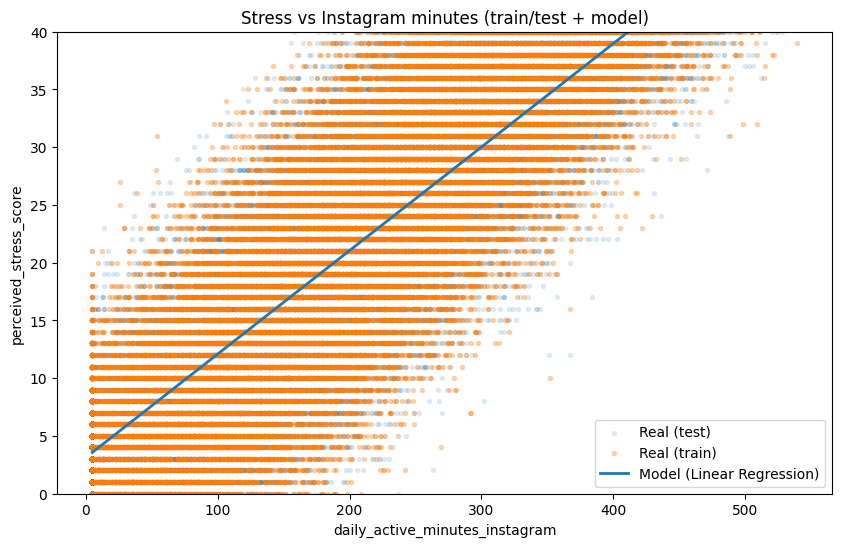

In [109]:
# FINAL CHART (keep only this)

# build plotting data directly from the split (no index issues)
train_plot = pd.concat([X_train_base, y_train_base], axis=1).sample(
    n=min(PLOT_SAMPLE//2, len(X_train_base)), random_state=RANDOM_STATE
)
test_plot = pd.concat([X_test_base, y_test_base], axis=1).sample(
    n=min(PLOT_SAMPLE//2, len(X_test_base)), random_state=RANDOM_STATE
)

# model line
x_min = min(train_plot[MAIN_X].min(), test_plot[MAIN_X].min())
x_max = max(train_plot[MAIN_X].max(), test_plot[MAIN_X].max())
x_line = np.linspace(x_min, x_max, 200)
y_line = baseline_model.predict(pd.DataFrame({MAIN_X: x_line}))

plt.figure(figsize=(10, 6))

# plot TEST first (behind) so TRAIN is visible
plt.scatter(test_plot[MAIN_X], test_plot[TARGET], s=8, alpha=0.12, label="Real (test)")
plt.scatter(train_plot[MAIN_X], train_plot[TARGET], s=8, alpha=0.30, label="Real (train)")
plt.plot(x_line, y_line, linewidth=2, label="Model (Linear Regression)")

plt.ylim(0, 40)
plt.title("Stress vs Instagram minutes (train/test + model)")
plt.xlabel(MAIN_X)
plt.ylabel(TARGET)
plt.legend()
plt.show()

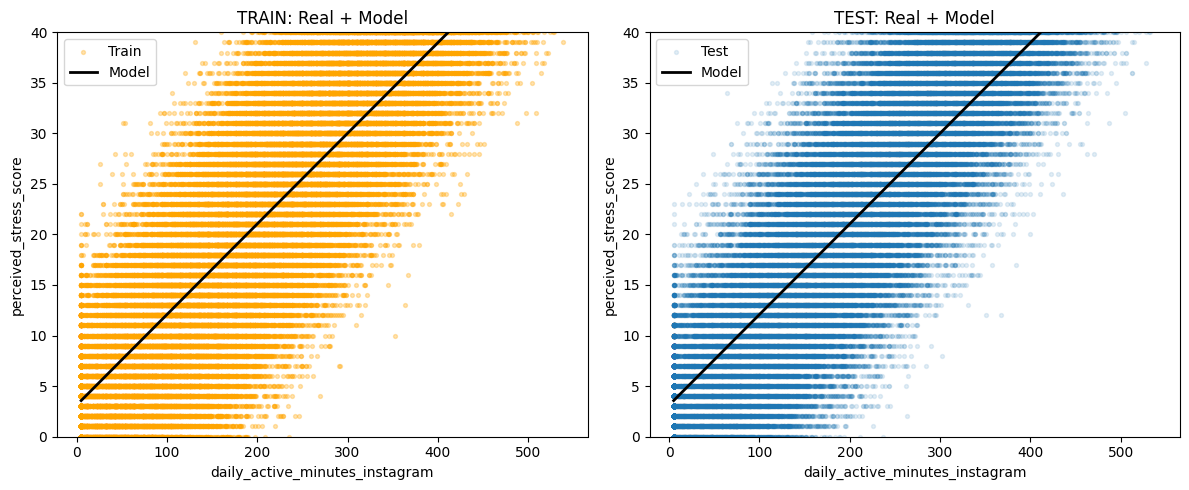

In [110]:
# FINAL SPLIT CHART (Train=blue, Test=red)

# Build plotting data directly from the split (no index issues)
train_plot = pd.concat([X_train_base, y_train_base], axis=1).sample(
    n=min(PLOT_SAMPLE, len(X_train_base)), random_state=RANDOM_STATE
)
test_plot = pd.concat([X_test_base, y_test_base], axis=1).sample(
    n=min(PLOT_SAMPLE, len(X_test_base)), random_state=RANDOM_STATE
)

# Model line
x_min = min(train_plot[MAIN_X].min(), test_plot[MAIN_X].min())
x_max = max(train_plot[MAIN_X].max(), test_plot[MAIN_X].max())
x_line = np.linspace(x_min, x_max, 200)
y_line = baseline_model.predict(pd.DataFrame({MAIN_X: x_line}))

plt.figure(figsize=(12, 5))

# TRAIN (blue)
plt.subplot(1, 2, 1)
plt.scatter(train_plot[MAIN_X], train_plot[TARGET], s=8, alpha=0.30,color="orange", label="Train")
plt.plot(x_line, y_line, linewidth=2, color="black", label="Model")
plt.ylim(0, 40)
plt.title("TRAIN: Real + Model")
plt.xlabel(MAIN_X)
plt.ylabel(TARGET)
plt.legend()

# TEST (red)
plt.subplot(1, 2, 2)
plt.scatter(test_plot[MAIN_X], test_plot[TARGET], s=8, alpha=0.12, label="Test")
plt.plot(x_line, y_line, linewidth=2, color="black", label="Model")
plt.ylim(0, 40)
plt.title("TEST: Real + Model")
plt.xlabel(MAIN_X)
plt.ylabel(TARGET)
plt.legend()

plt.tight_layout()
plt.show()

### Confounder-adjusted model 

In [111]:
# Code (build adjusted dataset)

cols = [TARGET, MAIN_X] + NUM_CONFOUNDERS + CAT_CONFOUNDERS
cols = [c for c in cols if c in df.columns]

adj = df[cols].copy()
adj = adj.dropna(subset=[TARGET])  # keep rows with target

X = adj.drop(columns=[TARGET])
y = adj[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

num_features = [c for c in ([MAIN_X] + NUM_CONFOUNDERS) if c in X.columns]
cat_features = [c for c in CAT_CONFOUNDERS if c in X.columns]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Numeric features: ['daily_active_minutes_instagram', 'sleep_hours_per_night', 'exercise_hours_per_week', 'weekly_work_hours', 'self_reported_happiness', 'daily_steps_count', 'age']
Categorical features: ['income_level', 'employment_status', 'education_level', 'has_children', 'relationship_status', 'urban_rural']


In [112]:
# Code (preprocess + Ridge regression + metrics)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

prep = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features)
    ]
)

adj_model = Pipeline(steps=[
    ("prep", prep),
    ("model", Ridge(alpha=1.0))
])

adj_model.fit(X_train, y_train)
pred_test = adj_model.predict(X_test)

mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
r2 = r2_score(y_test, pred_test)

print("Adjusted TEST (with confounders)")
print("MAE :", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R2  :", round(r2, 3))

Adjusted TEST (with confounders)
MAE : 3.691
RMSE: 4.619
R2  : 0.848


### Logistic regression 

In [113]:
# Code (create binary target + fit logistic)
# Define "high stress" using TRAIN only to avoid leakage
base2 = df[[MAIN_X, TARGET]].dropna()
X = base2[[MAIN_X]]
y = base2[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

threshold = y_train.quantile(0.75)  # top 25% = high stress
y_train_bin = (y_train >= threshold).astype(int)
y_test_bin  = (y_test >= threshold).astype(int)

clf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train_bin)
proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("Threshold (train 75%):", float(threshold))
print("AUC:", roc_auc_score(y_test_bin, proba))
print(classification_report(y_test_bin, pred))

Threshold (train 75%): 30.0
AUC: 0.9208672008688173
              precision    recall  f1-score   support

           0       0.89      0.92      0.90    226611
           1       0.75      0.68      0.71     82969

    accuracy                           0.85    309580
   macro avg       0.82      0.80      0.81    309580
weighted avg       0.85      0.85      0.85    309580



## Results Summary

**Baseline (Instagram minutes only):**
- MAE = 5.24, RMSE = 6.52, R² = 0.697  
Interpretation: Instagram time alone provides strong predictive power, but errors are still ~5–7 stress points on average.

**Adjusted model (with confounders):**
- MAE = 3.69, RMSE = 4.62, R² = 0.848  
Interpretation: Adding lifestyle/demographic variables substantially improves performance, indicating stress is better explained by multiple factors.

**Classification (High stress = top 25%, threshold = 30):**
- AUC = 0.921, accuracy ≈ 0.85  
- High-stress class: precision = 0.75, recall = 0.68  
Interpretation: Excellent discrimination; at default threshold the model is fairly precise but misses ~32% of high-stress users.

**Note:** Observational data → predictive/associational results, not causal claims.